In [1]:
def integral(estimate, ts):
    elements = np.ones(len(ts) - 1)
    for i in range(len(ts) - 1):
        elements[i] = (ts[i+1] - ts[i])*(estimates[i+1] + estimates[i])/2
    return sum(elements)

In [16]:
# serial MCMC

from scipy.stats import invgamma
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

pine = pd.read_table("pine.txt", delim_whitespace = True)
p = pine.values
ave_x = np.average(p[:, 1]).item()

mu_alpha = 3000
sigma_alpha = 10**6
mu_beta = 185
sigma_beta = 10**4
a = 3
b = 1/(2*300**2)

sample_iter = 100000
burn_in = 30000
N = np.shape(p)[0]
var = np.var(p[:, 1])

def sum1(beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = p[i, 0] - beta * (p[i, 1] - ave_x)
    return np.sum(elements)

def sum2(alpha):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 1] - ave_x)*(p[i, 0] - alpha)
    return np.sum(elements)

def sum3(alpha, beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 0] - alpha - beta*(p[i, 1] - ave_x))**2
    return np.sum(elements)

def loglike(alpha, beta, sigma):
    return N*np.log(1/(sigma*np.sqrt(2*np.pi))) - sum3(alpha, beta) / (2*sigma)

n = 20
c = 5

estimates = np.ones(n+1)
ts = np.ones(n+1)

for i in range(n+1):
    t = (i/n)**c
    ts[i] = t
    
    if i == 0:
        alphas = [3000]
        betas = [185]
        sigmas = [90000]
        
    else:
        alphas = [np.mean(alpha_sample).item()]
        betas = [np.mean(beta_sample).item()]
        sigmas = [np.mean(sigma_sample).item()]
    
    for j in range(sample_iter):
        
        location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
        scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
        r = norm.rvs(loc = location_alpha, scale = scale_alpha)
        alphas.append(r.item())
        
        location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta * var*N + sigmas[-1])
        scale_beta = (sigmas[-1] * sigma_beta) / (sigma_beta * var*N + sigmas[-1])
        q = norm.rvs(loc = location_beta, scale = scale_beta)
        betas.append(q.item())
        
        shape = N*t/2 + a
        invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
        s = invgamma.rvs(a = shape, scale = 1/ invrate)
        sigmas.append(s.item())
    
    alpha_sample = alphas[burn_in:]
    beta_sample = betas[burn_in:len(betas)]
    sigma_sample = sigmas[burn_in:len(sigmas)]
    
    box = np.ones(len(alpha_sample))
    for k, l in enumerate(alpha_sample):
        box[k] = loglike(l, beta_sample[k], sigma_sample[k])
    
    estimates[i] = np.average(box)
    
    

どのぐらいで収束するかを見る。
どれも1万回とかで十分収束しているのでは？

In [8]:
from scipy.stats import invgamma
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

pine = pd.read_table("pine.txt", delim_whitespace = True)
p = pine.values
ave_x = np.average(p[:, 1]).item()

mu_alpha = 3000
sigma_alpha = 10**6
mu_beta = 185
sigma_beta = 10**4
a = 3
b = 1/(2*300**2)

sample_iter = 10000
burn_in = 30
N = np.shape(p)[0]
var = np.var(p[:, 1])

def sum1(beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = p[i, 0] - beta * (p[i, 1] - ave_x)
    return np.sum(elements)

def sum2(alpha):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 1] - ave_x)*(p[i, 0] - alpha)
    return np.sum(elements)

def sum3(alpha, beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 0] - alpha - beta*(p[i, 1] - ave_x))**2
    return np.sum(elements)

def loglike(alpha, beta, sigma):
    return N*np.log(1/(sigma*np.sqrt(2*np.pi))) - sum3(alpha, beta) / (2*sigma)

n = 20
c = 5

alphas = [3000]
betas = [185]
sigmas = [90000]

t = (1/10)**2

for j in range(sample_iter):
        
    location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
    scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
    r = norm.rvs(loc = location_alpha, scale = scale_alpha)
    alphas.append(r.item())
        
    location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta * var*N + sigmas[-1])
    scale_beta = (sigmas[-1] * sigma_beta) / (sigma_beta * var*N + sigmas[-1])
    q = norm.rvs(loc = location_beta, scale = scale_beta)
    betas.append(q.item())

    shape = N*t/2 + a
    invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
    s = invgamma.rvs(a = shape, scale = 1/ invrate)
    sigmas.append(s.item())
    
#alpha_sample = alphas[burn_in:]
#beta_sample = betas[burn_in:len(betas)]
#sigma_sample = sigmas[burn_in:len(sigmas)]

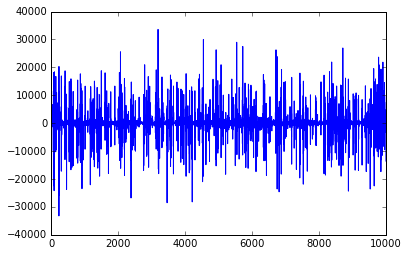

In [11]:
plt.plot(betas)

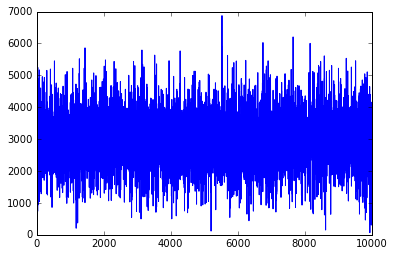

In [12]:
plt.plot(alphas)

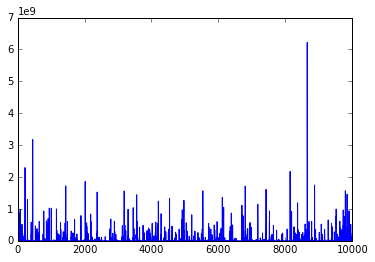

In [13]:
plt.plot(sigmas)

並列化

でも結果を次のルーぷに使うから無理やん

In [7]:
from scipy.stats import invgamma
from scipy.stats import norm
from multiprocessing import Pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

pine = pd.read_table("pine.txt", delim_whitespace = True)
p = pine.values
ave_x = np.average(p[:, 1]).item()

mu_alpha = 3000
sigma_alpha = 10**6
mu_beta = 185
sigma_beta = 10**4
a = 3
b = 1/(2*300**2)

# ここをいじってね。
sample_iter = 1000
burn_in = 30
m = 10
core = 3

N = np.shape(p)[0]
var = np.var(p[:, 1])

def sum1(beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = p[i, 0] - beta * (p[i, 1] - ave_x)
    return np.sum(elements)

def sum2(alpha):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 1] - ave_x)*(p[i, 0] - alpha)
    return np.sum(elements)

def sum3(alpha, beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 0] - alpha - beta*(p[i, 1] - ave_x))**2
    return np.sum(elements)

def loglike(alpha, beta, sigma):
    return N*np.log(1/(sigma*np.sqrt(2*np.pi))) - sum3(alpha, beta) / (2*sigma)

def function(w):
    if w < 100:
        
        n = 20
        c = 3
        estimates = np.ones(n+1)
        ts = np.ones(n+1)

        for i in range(n+1):
            t = (i/n)**c
            ts[i] = t

            if i == 0:
                alphas = [3000]
                betas = [185]
                sigmas = [90000]

            else:
                alphas = [np.mean(alpha_sample).item()]
                betas = [np.mean(beta_sample).item()]
                sigmas = [np.mean(sigma_sample).item()]

            for j in range(sample_iter):

                location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
                scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
                r = norm.rvs(loc = location_alpha, scale = scale_alpha)
                alphas.append(r.item())

                location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta * var*N + sigmas[-1])
                scale_beta = (sigmas[-1] * sigma_beta) / (sigma_beta * var*N + sigmas[-1])
                q = norm.rvs(loc = location_beta, scale = scale_beta)
                betas.append(q.item())

                shape = N*t/2 + a
                invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
                s = invgamma.rvs(a = shape, scale = 1/ invrate)
                sigmas.append(s.item())

            alpha_sample = alphas[burn_in:]
            beta_sample = betas[burn_in:len(betas)]
            sigma_sample = sigmas[burn_in:len(sigmas)]

            box = np.ones(len(alpha_sample))
            for k, l in enumerate(alpha_sample):
                box[k] = loglike(l, beta_sample[k], sigma_sample[k])

            estimates[i] = np.average(box)
        
        return estimates

if __name__ == '__main__':
    p = Pool(core) 
    result = p.map(function, range(m))

In [8]:
result

[array([-1281.52648633, -1189.67948291, -1008.69127558,  -851.92786789,
         -858.68470908,  -873.90565731,  -877.02651235,  -859.91947303,
         -878.3447848 ,  -869.96235801,  -873.28045876,  -875.61921931,
         -879.93889428,  -884.16577025,  -892.05108111,  -881.78634586,
         -882.36680116,  -895.66147305,  -885.68805034,  -893.36193867,
         -888.00551288]),
 array([-1281.52648633, -1189.67948291, -1008.69127558,  -851.92786789,
         -858.68470908,  -873.90565731,  -877.02651235,  -859.91947303,
         -878.3447848 ,  -869.96235801,  -873.28045876,  -875.61921931,
         -879.93889428,  -884.16577025,  -892.05108111,  -881.78634586,
         -882.36680116,  -895.66147305,  -885.68805034,  -893.36193867,
         -888.00551288]),
 array([-1281.52648633, -1189.67948291, -1008.69127558,  -851.92786789,
         -858.68470908,  -873.90565731,  -877.02651235,  -859.91947303,
         -878.3447848 ,  -869.96235801,  -873.28045876,  -875.61921931,
         -87